Rough volatility with Python
Jim Gatheral

For Python Quants, New York, Friday May 6, 2016



Acknowledgements
The code in this iPython notebook used to be in R. I am very grateful to Yves Hilpisch and Michael Schwed for translating my R-code to Python.

For slideshow functionality I use RISE by Damián Avila.

 
Outline of presentation
The time series of historical volatility

Scaling properties
The RFSV model

Pricing under rough volatility

Forecasting realized variance

The time series of variance swaps

Relating historical and implied

The time series of realized variance
Assuming an underlying variance process  vs , integrated variance  1δ∫t+δtvsds  may (in principle) be estimated arbitrarily accurately given enough price data.

In practice, market microstructure noise makes estimation harder at very high frequency.
Sophisticated estimators of integrated variance have been developed to adjust for market microstructure noise. See Gatheral and Oomen [6] (for example) for details of these.
The Oxford-Man Institute of Quantitative Finance makes historical realized variance (RV) estimates freely available at http://realized.oxford-man.ox.ac.uk. These estimates are updated daily.

Each day, for 21 different indices, all trades and quotes are used to estimate realized (or integrated) variance over the trading day from open to close.
Using daily RV estimates as proxies for instantaneous variance, we may investigate the time series properties of  vt  empirically.
First load all necessary Python libraries.

In [1]:
import warnings; warnings.simplefilter('ignore')
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
# from matplotlib.mlab import stineman_interp
import pandas as pd
import pandas_datareader.data as web
import requests
import zipfile as zi 
# import StringIO as sio
from sklearn import datasets, linear_model
import scipy.special as scsp
import statsmodels.api as sm
import math
import seaborn as sns; sns.set()
%matplotlib inline

In [2]:
# !pip3 install pandas_datareader

In [3]:

# url = 'https://realized.oxford-man.ox.ac.uk/images/oxfordmanrealizedvolatilityindices-0.2-final.zip'

In [4]:
# files1 = zi.ZipFile('./oxfordmanrealizedvolatilityindices.zip', 'r')

In [5]:
# import os
# files1.extractall(os.getcwd())

In [6]:
# df = pd.read_csv('./OxfordManRealizedVolatilityIndicess.csv', index_col=0, header=2 )
# df
df = pd.read_csv('./oxfordmanrealizedvolatilityindices.csv', index_col=0, header=0 )
df = df.reset_index()
df = df.rename(columns={'index':'DateID'})
df['DateID']= df['DateID'].apply(lambda x:str.replace(x[0:10],'-',''))
df = df.pivot(index='DateID',columns='Symbol',values=['rk_th2', 'medrv', 'rsv', 'rv5', 'open_to_close',
       'open_price', 'nobs', 'rk_twoscale', 'close_price', 'rsv_ss', 'bv_ss',
       'rk_parzen', 'bv', 'rv10', 'rv10_ss', 'close_time', 'open_time',
       'rv5_ss'])
list_ = [i[1][1:]+'.'+i[0] for i in df.columns]
df.columns = list_
df

,AEX.rk_th2,AORD.rk_th2,BFX.rk_th2,BSESN.rk_th2,BVLG.rk_th2,BVSP.rk_th2,DJI.rk_th2,FCHI.rk_th2,FTMIB.rk_th2,FTSE.rk_th2,...,OMXHPI.rv5_ss,OMXSPI.rv5_ss,OSEAX.rv5_ss,RUT.rv5_ss,SMSI.rv5_ss,SPX.rv5_ss,SSEC.rv5_ss,SSMI.rv5_ss,STI.rv5_ss,STOXX50E.rv5_ss
DateID,,,,,,,,,,,,,,,,,,,,,
20000103,0.000102,NaN,0.000180,0.000234,NaN,0.000300,0.000094,0.000204,NaN,NaN,...,NaN,NaN,NaN,0.000072,NaN,0.000141,NaN,NaN,0.000126,0.000313
20000104,0.000201,0.000046,0.000365,0.000527,NaN,0.000548,0.000092,0.000315,NaN,0.000209,...,NaN,NaN,NaN,0.000053,NaN,0.000224,0.000117,0.000137,0.000079,0.000226
20000105,0.000345,0.000156,0.000327,0.001017,NaN,0.000633,0.000110,0.000313,NaN,0.000149,...,NaN,NaN,NaN,0.000060,NaN,0.000314,0.000206,0.000157,0.001455,0.000464
20000106,0.000221,0.000024,0.000266,0.000268,NaN,0.000401,0.000082,0.000238,NaN,0.000132,...,NaN,NaN,NaN,0.000045,NaN,0.000131,0.000254,0.000124,0.000288,0.000104
20000107,0.000123,0.000034,0.000135,0.000385,NaN,0.000212,0.000059,0.000251,NaN,0.000148,...,NaN,NaN,NaN,0.000017,NaN,0.000094,0.000514,0.000083,0.000095,0.000122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20220622,0.000174,0.000047,0.000146,0.000055,NaN,0.000079,0.000127,0.000193,0.000075,0.000096,...,0.000099,0.000147,0.000416,0.000118,0.000110,0.000149,0.000065,0.000086,0.000055,0.000442
20220623,0.000156,0.000043,0.000108,0.000089,NaN,0.000086,0.000126,0.000145,0.000089,0.000051,...,0.000174,0.000138,0.000238,0.000140,0.000102,0.000136,0.000057,0.000061,0.000040,0.000149
20220624,0.000091,0.000024,0.000073,0.000068,NaN,0.000087,0.000061,0.000090,0.000050,0.000031,...,NaN,NaN,0.000098,0.000111,0.000079,0.000115,0.000060,0.000056,0.000027,0.000102


In [7]:
[i for i in df.columns.to_list() if 'SPX' in i]

['SPX.rk_th2',
 'SPX.medrv',
 'SPX.rsv',
 'SPX.rv5',
 'SPX.open_to_close',
 'SPX.open_price',
 'SPX.nobs',
 'SPX.rk_twoscale',
 'SPX.close_price',
 'SPX.rsv_ss',
 'SPX.bv_ss',
 'SPX.rk_parzen',
 'SPX.bv',
 'SPX.rv10',
 'SPX.rv10_ss',
 'SPX.close_time',
 'SPX.open_time',
 'SPX.rv5_ss']

In [8]:
df[[i for i in df.columns.to_list() if 'SPX' in i]]

,SPX.rk_th2,SPX.medrv,SPX.rsv,SPX.rv5,SPX.open_to_close,SPX.open_price,SPX.nobs,SPX.rk_twoscale,SPX.close_price,SPX.rsv_ss,SPX.bv_ss,SPX.rk_parzen,SPX.bv,SPX.rv10,SPX.rv10_ss,SPX.close_time,SPX.open_time,SPX.rv5_ss
DateID,,,,,,,,,,,,,,,,,,
20000103,0.000130,0.000058,0.000096,0.000141,-0.011602,1471.21,1554.0,0.000122,1454.24,0.000096,0.000141,0.000340,0.000141,0.000164,0.000164,145959.0,83004.0,0.000141
20000104,0.000162,0.000067,0.000180,0.000224,-0.035102,1449.00,1564.0,0.000142,1399.02,0.000180,0.000173,0.000215,0.000173,0.000295,0.000295,150000.0,83009.0,0.000224
20000105,0.000240,0.000142,0.000131,0.000314,0.004625,1395.62,1552.0,0.000219,1402.09,0.000131,0.000303,0.000163,0.000303,0.000267,0.000267,150003.0,83012.0,0.000314
20000106,0.000132,0.000070,0.000056,0.000131,0.002991,1398.87,1561.0,0.000127,1403.06,0.000056,0.000128,0.000067,0.000128,0.000115,0.000115,145954.0,83005.0,0.000131
20000107,0.000095,0.000049,0.000023,0.000094,0.026293,1403.45,1540.0,0.000091,1440.84,0.000023,0.000079,0.000215,0.000079,0.000121,0.000121,150000.0,83000.0,0.000094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20220622,0.000137,0.000089,0.000066,0.000149,0.006609,3733.89,23400.0,0.000143,3758.65,0.000066,0.000138,0.000194,0.000138,0.000149,0.000149,160000.0,93001.0,0.000149
20220623,0.000150,0.000049,0.000063,0.000136,0.005558,3774.71,23401.0,0.000144,3795.75,0.000063,0.000131,0.000085,0.000131,0.000093,0.000093,160001.0,93001.0,0.000136
20220624,0.000066,0.000029,0.000014,0.000115,0.023762,3821.75,23400.0,0.000068,3913.65,0.000014,0.000091,0.000129,0.000091,0.000137,0.000137,160000.0,93001.0,0.000115


In [9]:
rv1 = pd.DataFrame(index=df.index)


In [10]:
for col in df.columns:
    if '.rsv' in col:
        rv1[col] = df[col]
rv1.index = [dt.datetime.strptime(str(date), "%Y%m%d") for date in rv1.index.values]

In [11]:
# rv1 = rv1[rv1['Symbol']=='.SPX'][['rv5']]
# rv1[rv1.index=='2000-01-03']


In [12]:
#rv1.columns

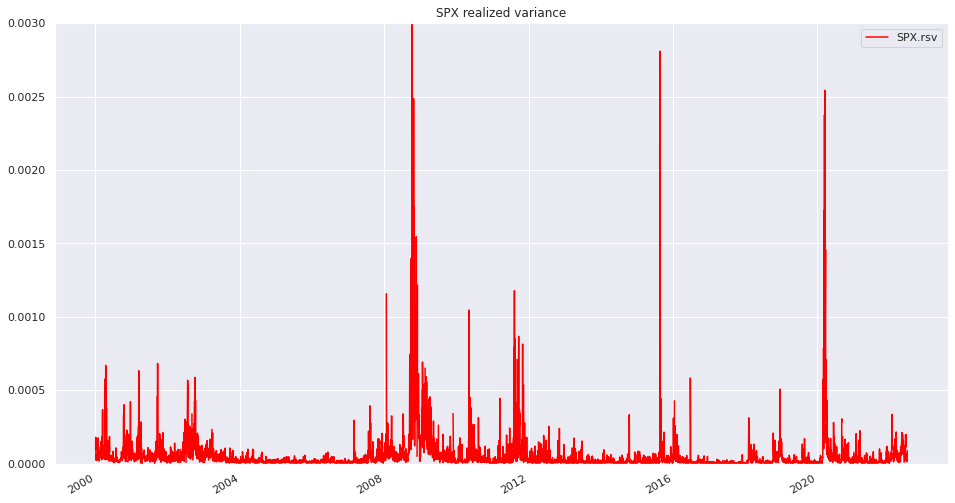

In [13]:
spx = pd.DataFrame(rv1['SPX.rsv'])
spx.plot(color='red', grid=True, title='SPX realized variance',
         figsize=(16, 9), ylim=(0,0.003));

In [14]:
SPX =pd.read_csv('./SPX.csv',sep='\t')



In [15]:
SPX['Date'] = pd.to_datetime(SPX['Date'])

In [16]:
SPX = SPX.drop(columns=['Unnamed: 0'])


In [17]:
#import matplotlib.pyplot as plt
#plt.plot(SPX['Date'],SPX['Adj Close'])
#plt.figure(figsize=(14, 8), dpi=200)
#plt.show()

In [18]:

spx['sqrt']= np.sqrt(spx['SPX.rsv'])
spx['log_sqrt'] = np.log(spx['sqrt'])

def del_Raw(q, x): 
    return [np.mean(np.abs(spx['log_sqrt'] - spx['log_sqrt'].shift(lag)) ** q)
            for lag in x]

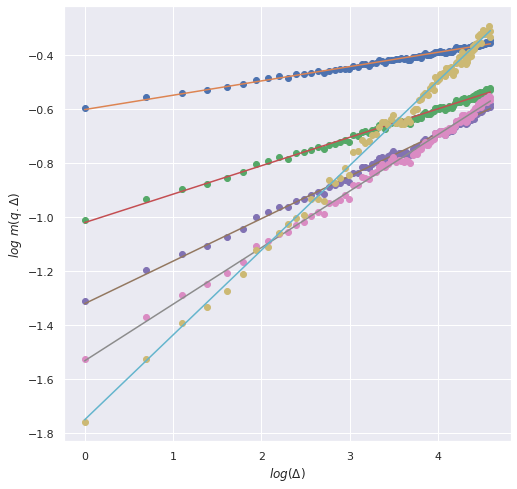

In [19]:
plt.figure(figsize=(8, 8))
plt.xlabel('$log(\Delta)$')
plt.ylabel('$log\  m(q.\Delta)$')
plt.ylim=(-3, -.5)

zeta_q = list()
qVec = np.array([.5, 1, 1.5, 2, 3])
x = np.arange(1, 100)
for q in qVec:
    plt.plot(np.log(x), np.log(del_Raw(q, x)), 'o') 
    model = np.polyfit(np.log(x), np.log(del_Raw(q, x)), 1)
    plt.plot(np.log(x), np.log(x) * model[0] + model[1])
    zeta_q.append(model[0])
    

0.10442252633843498


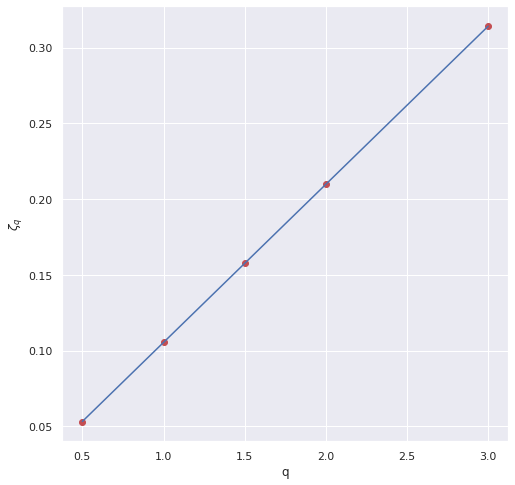

In [20]:

plt.figure(figsize=(8,8))
plt.xlabel('q')
plt.ylabel('$\zeta_{q}$')
plt.plot(qVec, zeta_q, 'or')

line = np.polyfit(qVec[:4], zeta_q[:4],1)
plt.plot(qVec, line[0] * qVec + line[1])
h_est= line[0]
print(h_est)

In [21]:

def dlsig2(sic, x, pr=False):
    if pr:
        a= np.array([(sig-sig.shift(lag)).dropna() for lag in x])
        a=a ** 2
        print (a.info())
    return [np.mean((sig-sig.shift(lag)).dropna() ** 2) for lag in x]

In [22]:
# h = list()
# nu = list()
# name_list = list()
# time_list = list()
# for i in range(300,spx.shape[0],10):
#     for col in rv1.columns:
#         try:

#             sig = spx.iloc[i-300:i,[0]][col]
#             print(sig)
#             sig = np.log(np.sqrt(sig))
#             sig = sig.dropna()
#             model = np.polyfit(np.log(x), np.log(dlsig2(sig, x)), 1)
#             nu.append(np.sqrt(np.exp(model[1])))
#             h.append(model[0]/2.)
#             name_list.append(col)
#             time_list.append(spx.iloc[[i],:].index[0])
#         except:
#             pass
    

h = list()
nu = list()

for col in rv1.columns:
    sig = rv1[col]
    sig = np.log(np.sqrt(sig))
    sig = sig.dropna()
    model = np.polyfit(np.log(x), np.log(dlsig2(sig, x)), 1)
    nu.append(np.sqrt(np.exp(model[1])))
    h.append(model[0]/2.)
    
OxfordH = pd.DataFrame({'names':rv1.columns, 'h_est': h, 'nu_est': nu})

In [23]:
# OxfordH = pd.DataFrame({'names':name_list, 'h_est': h, 'nu_est': nu,'dt':time_list})
# OxfordH
OxfordH

,names,h_est,nu_est
0,AEX.rsv,NaN,NaN
1,AORD.rsv,0.057554,0.536911
2,BFX.rsv,0.106880,0.352962
3,BSESN.rsv,NaN,NaN
4,BVLG.rsv,NaN,NaN
...,...,...,...
57,SPX.rsv_ss,0.103988,0.468382
58,SSEC.rsv_ss,0.090876,0.433111
59,SSMI.rsv_ss,0.126401,0.313327
60,STI.rsv_ss,NaN,NaN


In [24]:
# OxfordH[['h_est','nu_est']].plot()

In [25]:

from scipy.stats import norm
def plotScaling(j, scaleFactor):
    col_name = rv1.columns[j]
    v = rv1[col_name]
    x = np.arange(1,101)
    
    def xDel(x, lag):
        return x-x.shift(lag)
    
    def sdl(lag):
        return (xDel(np.log(v), lag)).std()
    
    sd1 = (xDel(np.log(v), 1)).std()
    h = OxfordH['h_est'][j]
    f, ax = plt.subplots(2,2,sharex=False, sharey=False, figsize=(10, 10))
    
    for i_0 in range(0, 2):
        for i_1 in range(0, 2):
            la = scaleFactor ** (i_1*1+i_0*2)
        
            hist_val = xDel(np.log(v), la).dropna()
            std = hist_val.std()
            mean = hist_val.mean()
        
            ax[i_0][i_1].set_title('Lag = %s Days' %la)
            n, bins, patches = ax[i_0][i_1].hist(hist_val.values, bins=100,
                                   density=True, facecolor='green',alpha=0.2)
            ax[i_0][i_1].plot(bins, norm.pdf(bins,mean,std), "r")
            ax[i_0][i_1].plot(bins, norm.pdf(bins,0,sd1 * la ** h), "b--")
            hist_val.plot(kind='density', ax=ax[i_0][i_1])
        

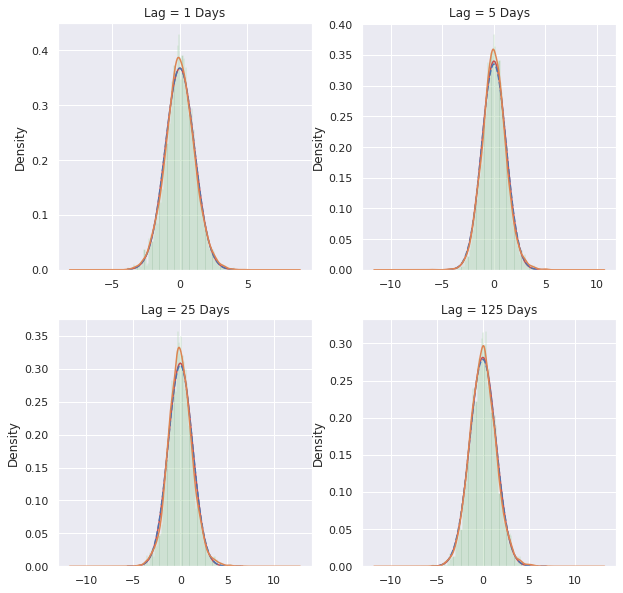

In [26]:
plotScaling(1,5)

In [27]:
def c_tilde(h):
    return scsp.gamma(3. / 2. - h) / scsp.gamma(h + 1. / 2.) * scsp.gamma(2. - 2. * h)

def forecast_XTS(rvdata, h, date, nLags, delta, nu):
    i = np.arange(nLags)
    cf = 1./((i + 1. / 2.) ** (h + 1. / 2.) * (i + 1. / 2. + delta))
    ldata = rvdata.truncate(after=date)
    l = len(ldata)
    ldata = np.log(ldata.iloc[l - nLags:])
    ldata['cf'] = np.fliplr([cf])[0]
    # print ldata
    ldata = ldata.dropna()
    fcst = (ldata.iloc[:, 0] * ldata['cf']).sum() / sum(ldata['cf'])
    
    return math.exp(fcst + 2 * nu ** 2 * c_tilde(h) * delta ** (2 * h))

In [28]:
h = OxfordH[OxfordH['names']=='SPX.rsv']['h_est'].values[0] 
h

0.10398750046434439

In [29]:

rvdata = pd.DataFrame(rv1['SPX.rsv'])
nu  = OxfordH[OxfordH['names']=='SPX.rsv']['nu_est'].values[0] # Vol of vol estimate for SPX
h = OxfordH[OxfordH['names']=='SPX.rsv']['h_est'].values[0] 
n = len(rvdata)
delta = 1
nLags = 500
dates = rvdata.iloc[nLags:n-delta].index
rv_predict = [forecast_XTS(rvdata, h=h, date=d, nLags=nLags,
                           delta=delta, nu=nu) for d in dates]
rv_actual = rvdata.iloc[nLags+delta:n].values

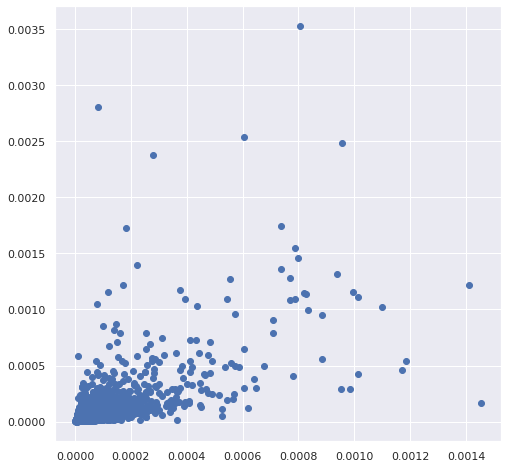

In [30]:
plt.figure(figsize=(8, 8))
plt.plot(rv_predict, rv_actual, 'bo');

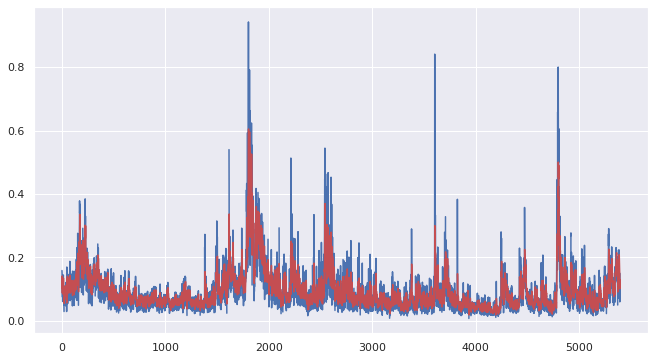

In [31]:
plt.figure(figsize=(11, 6))
vol_actual = np.sqrt(np.multiply(rv_actual,252))
vol_predict = np.sqrt(np.multiply(rv_predict,252))
plt.plot(vol_actual, "b")
plt.plot(vol_predict, "r");

In [32]:
df_rv_predict = pd.DataFrame({"Dates":dates,"rv_predict":rv_predict})
df_rv_predict            

,Dates,rv_predict
0,2001-11-26,0.000031
1,2001-11-27,0.000069
2,2001-11-28,0.000079
3,2001-11-29,0.000053
4,2001-11-30,0.000041
...,...,...
5388,2022-06-21,0.000118
5389,2022-06-22,0.000094
5390,2022-06-23,0.000088
5391,2022-06-24,0.000041


In [33]:
spx = spx.reset_index()

In [34]:
spx = spx.rename(columns={'index':'Date'})

In [35]:
df_all = pd.merge(spx,SPX,how='left',on=['Date'])
df_all

,Date,SPX.rsv,sqrt,log_sqrt,Adj Close
0,2000-01-03,0.000096,0.009805,-4.624887,1455.219971
1,2000-01-04,0.000180,0.013419,-4.311101,1399.420044
2,2000-01-05,0.000131,0.011439,-4.470735,1402.109985
3,2000-01-06,0.000056,0.007463,-4.897814,1403.449951
4,2000-01-07,0.000023,0.004802,-5.338791,1441.469971
...,...,...,...,...,...
5889,2022-06-22,0.000066,0.008147,-4.810114,3759.889893
5890,2022-06-23,0.000063,0.007956,-4.833788,3795.729980
5891,2022-06-24,0.000014,0.003774,-5.579647,3911.739990
5892,2022-06-27,0.000063,0.007919,-4.838520,3900.110107


In [36]:
# df_all['SPX.rv5'] = df_all['SPX.rv5']*df_all['SPX.rv5']

In [37]:
df_all['log_s'] = np.log(df_all['Adj Close'])
df_all['log_v'] = np.log(df_all['SPX.rsv'])
df_all

,Date,SPX.rsv,sqrt,log_sqrt,Adj Close,log_s,log_v
0,2000-01-03,0.000096,0.009805,-4.624887,1455.219971,7.282912,-9.249773
1,2000-01-04,0.000180,0.013419,-4.311101,1399.420044,7.243813,-8.622203
2,2000-01-05,0.000131,0.011439,-4.470735,1402.109985,7.245734,-8.941470
3,2000-01-06,0.000056,0.007463,-4.897814,1403.449951,7.246689,-9.795627
4,2000-01-07,0.000023,0.004802,-5.338791,1441.469971,7.273419,-10.677581
...,...,...,...,...,...,...,...
5889,2022-06-22,0.000066,0.008147,-4.810114,3759.889893,8.232145,-9.620229
5890,2022-06-23,0.000063,0.007956,-4.833788,3795.729980,8.241632,-9.667576
5891,2022-06-24,0.000014,0.003774,-5.579647,3911.739990,8.271738,-11.159295
5892,2022-06-27,0.000063,0.007919,-4.838520,3900.110107,8.268760,-9.677040


In [38]:
df_all['diff_log_s'] = df_all['log_s'].diff()
df_all['diff_log_v'] = df_all['log_v'].diff()
df_all

,Date,SPX.rsv,sqrt,log_sqrt,Adj Close,log_s,log_v,diff_log_s,diff_log_v
0,2000-01-03,0.000096,0.009805,-4.624887,1455.219971,7.282912,-9.249773,NaN,NaN
1,2000-01-04,0.000180,0.013419,-4.311101,1399.420044,7.243813,-8.622203,-0.039099,0.627571
2,2000-01-05,0.000131,0.011439,-4.470735,1402.109985,7.245734,-8.941470,0.001920,-0.319268
3,2000-01-06,0.000056,0.007463,-4.897814,1403.449951,7.246689,-9.795627,0.000955,-0.854157
4,2000-01-07,0.000023,0.004802,-5.338791,1441.469971,7.273419,-10.677581,0.026730,-0.881954
...,...,...,...,...,...,...,...,...,...
5889,2022-06-22,0.000066,0.008147,-4.810114,3759.889893,8.232145,-9.620229,-0.001302,NaN
5890,2022-06-23,0.000063,0.007956,-4.833788,3795.729980,8.241632,-9.667576,0.009487,-0.047347
5891,2022-06-24,0.000014,0.003774,-5.579647,3911.739990,8.271738,-11.159295,0.030106,-1.491719
5892,2022-06-27,0.000063,0.007919,-4.838520,3900.110107,8.268760,-9.677040,-0.002977,1.482255


In [39]:
df_all['sqrt'] = np.sqrt(df_all['SPX.rsv'])

In [40]:
df_all['shift_sqrt_v'] = df_all['sqrt'].shift(1)
df_all

,Date,SPX.rsv,sqrt,log_sqrt,Adj Close,log_s,log_v,diff_log_s,diff_log_v,shift_sqrt_v
0,2000-01-03,0.000096,0.009805,-4.624887,1455.219971,7.282912,-9.249773,NaN,NaN,NaN
1,2000-01-04,0.000180,0.013419,-4.311101,1399.420044,7.243813,-8.622203,-0.039099,0.627571,0.009805
2,2000-01-05,0.000131,0.011439,-4.470735,1402.109985,7.245734,-8.941470,0.001920,-0.319268,0.013419
3,2000-01-06,0.000056,0.007463,-4.897814,1403.449951,7.246689,-9.795627,0.000955,-0.854157,0.011439
4,2000-01-07,0.000023,0.004802,-5.338791,1441.469971,7.273419,-10.677581,0.026730,-0.881954,0.007463
...,...,...,...,...,...,...,...,...,...,...
5889,2022-06-22,0.000066,0.008147,-4.810114,3759.889893,8.232145,-9.620229,-0.001302,NaN,NaN
5890,2022-06-23,0.000063,0.007956,-4.833788,3795.729980,8.241632,-9.667576,0.009487,-0.047347,0.008147
5891,2022-06-24,0.000014,0.003774,-5.579647,3911.739990,8.271738,-11.159295,0.030106,-1.491719,0.007956
5892,2022-06-27,0.000063,0.007919,-4.838520,3900.110107,8.268760,-9.677040,-0.002977,1.482255,0.003774


In [41]:
df_all = df_all.dropna()
df_all

,Date,SPX.rsv,sqrt,log_sqrt,Adj Close,log_s,log_v,diff_log_s,diff_log_v,shift_sqrt_v
1,2000-01-04,0.000180,0.013419,-4.311101,1399.420044,7.243813,-8.622203,-0.039099,0.627571,0.009805
2,2000-01-05,0.000131,0.011439,-4.470735,1402.109985,7.245734,-8.941470,0.001920,-0.319268,0.013419
3,2000-01-06,0.000056,0.007463,-4.897814,1403.449951,7.246689,-9.795627,0.000955,-0.854157,0.011439
4,2000-01-07,0.000023,0.004802,-5.338791,1441.469971,7.273419,-10.677581,0.026730,-0.881954,0.007463
5,2000-01-10,0.000034,0.005862,-5.139191,1457.599976,7.284547,-10.278382,0.011128,0.399200,0.004802
...,...,...,...,...,...,...,...,...,...,...
5886,2022-06-17,0.000117,0.010820,-4.526353,3674.840088,8.209265,-9.052706,0.002198,-0.488075,0.013811
5890,2022-06-23,0.000063,0.007956,-4.833788,3795.729980,8.241632,-9.667576,0.009487,-0.047347,0.008147
5891,2022-06-24,0.000014,0.003774,-5.579647,3911.739990,8.271738,-11.159295,0.030106,-1.491719,0.007956
5892,2022-06-27,0.000063,0.007919,-4.838520,3900.110107,8.268760,-9.677040,-0.002977,1.482255,0.003774


In [42]:
df_all['diff_log_s_div_sqrt_v'] = df_all['diff_log_s']/df_all['shift_sqrt_v']
df_all

,Date,SPX.rsv,sqrt,log_sqrt,Adj Close,log_s,log_v,diff_log_s,diff_log_v,shift_sqrt_v,diff_log_s_div_sqrt_v
1,2000-01-04,0.000180,0.013419,-4.311101,1399.420044,7.243813,-8.622203,-0.039099,0.627571,0.009805,-3.987772
2,2000-01-05,0.000131,0.011439,-4.470735,1402.109985,7.245734,-8.941470,0.001920,-0.319268,0.013419,0.143108
3,2000-01-06,0.000056,0.007463,-4.897814,1403.449951,7.246689,-9.795627,0.000955,-0.854157,0.011439,0.083506
4,2000-01-07,0.000023,0.004802,-5.338791,1441.469971,7.273419,-10.677581,0.026730,-0.881954,0.007463,3.581720
5,2000-01-10,0.000034,0.005862,-5.139191,1457.599976,7.284547,-10.278382,0.011128,0.399200,0.004802,2.317488
...,...,...,...,...,...,...,...,...,...,...,...
5886,2022-06-17,0.000117,0.010820,-4.526353,3674.840088,8.209265,-9.052706,0.002198,-0.488075,0.013811,0.159185
5890,2022-06-23,0.000063,0.007956,-4.833788,3795.729980,8.241632,-9.667576,0.009487,-0.047347,0.008147,1.164497
5891,2022-06-24,0.000014,0.003774,-5.579647,3911.739990,8.271738,-11.159295,0.030106,-1.491719,0.007956,3.783849
5892,2022-06-27,0.000063,0.007919,-4.838520,3900.110107,8.268760,-9.677040,-0.002977,1.482255,0.003774,-0.788972


In [43]:
corr = np.corrcoef(df_all['diff_log_s_div_sqrt_v'],df_all['diff_log_v'])[0][1]

In [44]:
h_hat = OxfordH[OxfordH['names']=='SPX.rsv']['h_est'].values[0]

In [47]:
rho = corr*(h_hat+0.5)/np.sqrt(2*h_hat)
rho

-0.7297722843652522

In [48]:
rho_hat = np.sqrt(1-rho**2)
rho_hat

0.6836902902428272

In [49]:
OxfordH[OxfordH['names']=='SPX.rsv']

,names,h_est,nu_est
26,SPX.rsv,0.103988,0.468382


In [50]:
df_all['rolling_1m'] = df_all['SPX.rsv'].rolling(30).sum()/30
df_all['rolling_1m_1'] = df_all['SPX.rsv'].rolling(29).sum()/29

In [51]:
df_all

,Date,SPX.rsv,sqrt,log_sqrt,Adj Close,log_s,log_v,diff_log_s,diff_log_v,shift_sqrt_v,diff_log_s_div_sqrt_v,rolling_1m,rolling_1m_1
1,2000-01-04,0.000180,0.013419,-4.311101,1399.420044,7.243813,-8.622203,-0.039099,0.627571,0.009805,-3.987772,NaN,NaN
2,2000-01-05,0.000131,0.011439,-4.470735,1402.109985,7.245734,-8.941470,0.001920,-0.319268,0.013419,0.143108,NaN,NaN
3,2000-01-06,0.000056,0.007463,-4.897814,1403.449951,7.246689,-9.795627,0.000955,-0.854157,0.011439,0.083506,NaN,NaN
4,2000-01-07,0.000023,0.004802,-5.338791,1441.469971,7.273419,-10.677581,0.026730,-0.881954,0.007463,3.581720,NaN,NaN
5,2000-01-10,0.000034,0.005862,-5.139191,1457.599976,7.284547,-10.278382,0.011128,0.399200,0.004802,2.317488,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5886,2022-06-17,0.000117,0.010820,-4.526353,3674.840088,8.209265,-9.052706,0.002198,-0.488075,0.013811,0.159185,0.000115,0.000111
5890,2022-06-23,0.000063,0.007956,-4.833788,3795.729980,8.241632,-9.667576,0.009487,-0.047347,0.008147,1.164497,0.000110,0.000107
5891,2022-06-24,0.000014,0.003774,-5.579647,3911.739990,8.271738,-11.159295,0.030106,-1.491719,0.007956,3.783849,0.000104,0.000101
5892,2022-06-27,0.000063,0.007919,-4.838520,3900.110107,8.268760,-9.677040,-0.002977,1.482255,0.003774,-0.788972,0.000100,0.000097


In [94]:
df_new = pd.read_excel("VARIANCESWAP.xlsx", engine='openpyxl',header=5)
df_new

,Dates,VAR_SWAP_1M_LV,VAR_SWAP_3M_LV,VAR_SWAP_6M_LV,VAR_SWAP_12M_LV
0,2008-11-04,45.781500,46.273630,43.479500,40.999440
1,2008-11-05,50.383750,49.729380,45.918250,42.647130
2,2008-11-06,60.280560,56.794560,51.461810,46.078310
3,2008-11-07,54.587940,53.353060,48.882630,44.214190
4,2008-11-10,56.355380,54.289690,49.609000,45.247130
...,...,...,...,...,...
3430,2022-08-01,22.538050,24.473735,26.027563,27.453327
3431,2022-08-02,23.390818,25.028260,26.588154,27.749637
3432,2022-08-03,21.595915,23.744925,25.642710,27.074926
3433,2022-08-04,21.675047,24.107518,25.995660,27.286304


In [95]:
for i in ['VAR_SWAP_1M_LV', 'VAR_SWAP_3M_LV', 'VAR_SWAP_6M_LV',
       'VAR_SWAP_12M_LV']:
    
    df_new[i] = df_new[i]/100

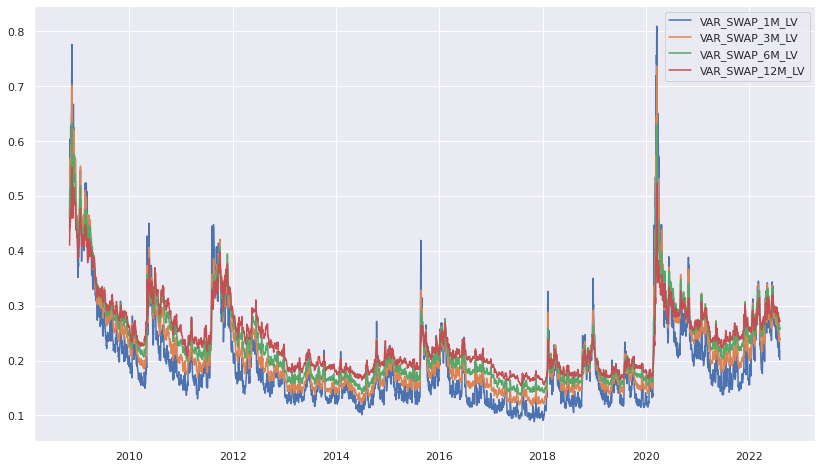

In [96]:
import matplotlib.pyplot as plt

plt.figure(figsize =(14,8))
plt.plot(df_new['Dates'], df_new['VAR_SWAP_1M_LV'],label='VAR_SWAP_1M_LV')
plt.plot(df_new['Dates'], df_new['VAR_SWAP_3M_LV'],label='VAR_SWAP_3M_LV')
plt.plot(df_new['Dates'], df_new['VAR_SWAP_6M_LV'],label='VAR_SWAP_6M_LV')
plt.plot(df_new['Dates'], df_new['VAR_SWAP_12M_LV'],label='VAR_SWAP_12M_LV')
plt.legend()
plt.show()

In [97]:
for i in ['VAR_SWAP_1M_LV', 'VAR_SWAP_3M_LV', 'VAR_SWAP_6M_LV',
       'VAR_SWAP_12M_LV']:
    
    df_new[i] = df_new[i]*df_new[i]

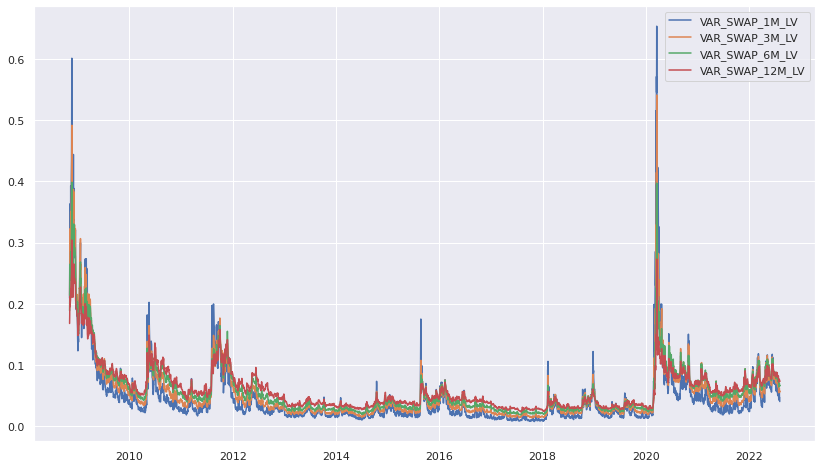

In [98]:

plt.figure(figsize =(14,8))
plt.plot(df_new['Dates'], df_new['VAR_SWAP_1M_LV'],label='VAR_SWAP_1M_LV')
plt.plot(df_new['Dates'], df_new['VAR_SWAP_3M_LV'],label='VAR_SWAP_3M_LV')
plt.plot(df_new['Dates'], df_new['VAR_SWAP_6M_LV'],label='VAR_SWAP_6M_LV')
plt.plot(df_new['Dates'], df_new['VAR_SWAP_12M_LV'],label='VAR_SWAP_12M_LV')
plt.legend()
plt.show()

In [99]:
# list_new = list()
# for i in range(1,len(df_new['VAR_SWAP_1M_LV'].values)):
    
#     list_new.append(df_new['VAR_SWAP_1M_LV'].values[i]*30-df_new['VAR_SWAP_1M_LV'].values[i-1]*29)
# list_new   

In [100]:
list_new_1m = list()
list_dt_1m = list()
for i in range(0,len(df_new['VAR_SWAP_1M_LV'].values)):
    if i<len(df_new['VAR_SWAP_1M_LV'].values)-30:
        list_new_1m.append((df_new['VAR_SWAP_1M_LV'].values[i+30]*31/30-df_new['VAR_SWAP_1M_LV'].values[i]*1/30)/1)
        list_dt_1m.append(df_new['Dates'].values[i+30])
    else:
        pass 
        

df_1m = pd.DataFrame({'Dates':list_dt_1m,'1m':list_new_1m})  
df_1m

,Dates,1m
0,2008-12-17,0.232382
1,2008-12-18,0.221041
2,2008-12-19,0.185797
3,2008-12-22,0.196609
4,2008-12-23,0.195140
...,...,...
3400,2022-08-01,0.048729
3401,2022-08-02,0.053432
3402,2022-08-03,0.045260
3403,2022-08-04,0.045725


In [101]:
list_new_3m = list()
list_dt_3m = list()
for i in range(0,len(df_new['VAR_SWAP_3M_LV'].values)):
    if i<len(df_new['VAR_SWAP_3M_LV'].values)-90:
        list_new_3m.append((df_new['VAR_SWAP_3M_LV'].values[i+90]*91/90-df_new['VAR_SWAP_3M_LV'].values[i]*1/90)/1)
        list_dt_3m.append(df_new['Dates'].values[i+90])
    else:
        pass
        

df_3m = pd.DataFrame({'Dates':list_dt_3m,'3m':list_new_3m})  
df_3m

,Dates,3m
0,2009-03-17,0.164634
1,2009-03-18,0.161028
2,2009-03-19,0.187055
3,2009-03-20,0.215517
4,2009-03-23,0.193360
...,...,...
3340,2022-08-01,0.059911
3341,2022-08-02,0.062657
3342,2022-08-03,0.056390
3343,2022-08-04,0.058155


In [102]:
list_new_6m = list()
list_dt_6m = list()
for i in range(0,len(df_new['VAR_SWAP_6M_LV'].values)):
    if i<len(df_new['VAR_SWAP_6M_LV'].values)-180:
        list_new_6m.append((df_new['VAR_SWAP_6M_LV'].values[i+180]*181/180-df_new['VAR_SWAP_6M_LV'].values[i]*1/180)/1)
        list_dt_6m.append(df_new['Dates'].values[i+180])
    else:
        pass
        

df_6m = pd.DataFrame({'Dates':list_dt_6m,'6m':list_new_6m})  
df_6m

,Dates,6m
0,2009-07-24,0.078108
1,2009-07-27,0.079487
2,2009-07-28,0.084275
3,2009-07-29,0.087259
4,2009-07-30,0.084946
...,...,...
3250,2022-08-01,0.067824
3251,2022-08-02,0.070792
3252,2022-08-03,0.065835
3253,2022-08-04,0.067664


In [103]:
list_new_1Y = list()
list_dt_1Y = list()
for i in range(0,len(df_new['VAR_SWAP_12M_LV'].values)):
    if i<len(df_new['VAR_SWAP_12M_LV'].values)-365:
        list_new_1Y.append((df_new['VAR_SWAP_12M_LV'].values[i+365]*366/365-df_new['VAR_SWAP_12M_LV'].values[i]*1/365)/1)
        list_dt_1Y.append(df_new['Dates'].values[i+365])
    else:
        pass 
        

df_1Y = pd.DataFrame({'Dates':list_dt_1Y,'1Y':list_new_1Y})  
df_1Y

,Dates,1Y
0,2010-04-26,0.058872
1,2010-04-27,0.066728
2,2010-04-28,0.066526
3,2010-04-29,0.063820
4,2010-04-30,0.073040
...,...,...
3065,2022-08-01,0.075345
3066,2022-08-02,0.076985
3067,2022-08-03,0.073273
3068,2022-08-04,0.074432


In [104]:
from functools import reduce
df_vsnm = reduce(lambda x, y: pd.merge(x, y, on='Dates', how='left'), [df_1m, df_3m, df_6m,df_1Y])
df_vsnm

,Dates,1m,3m,6m,1Y
0,2008-12-17,0.232382,NaN,NaN,NaN
1,2008-12-18,0.221041,NaN,NaN,NaN
2,2008-12-19,0.185797,NaN,NaN,NaN
3,2008-12-22,0.196609,NaN,NaN,NaN
4,2008-12-23,0.195140,NaN,NaN,NaN
...,...,...,...,...,...
3400,2022-08-01,0.048729,0.059911,0.067824,0.075345
3401,2022-08-02,0.053432,0.062657,0.070792,0.076985
3402,2022-08-03,0.045260,0.056390,0.065835,0.073273
3403,2022-08-04,0.045725,0.058155,0.067664,0.074432


In [105]:
df_vsnm.to_csv("./df_vsnm_nosqrt.csv",sep='\t')

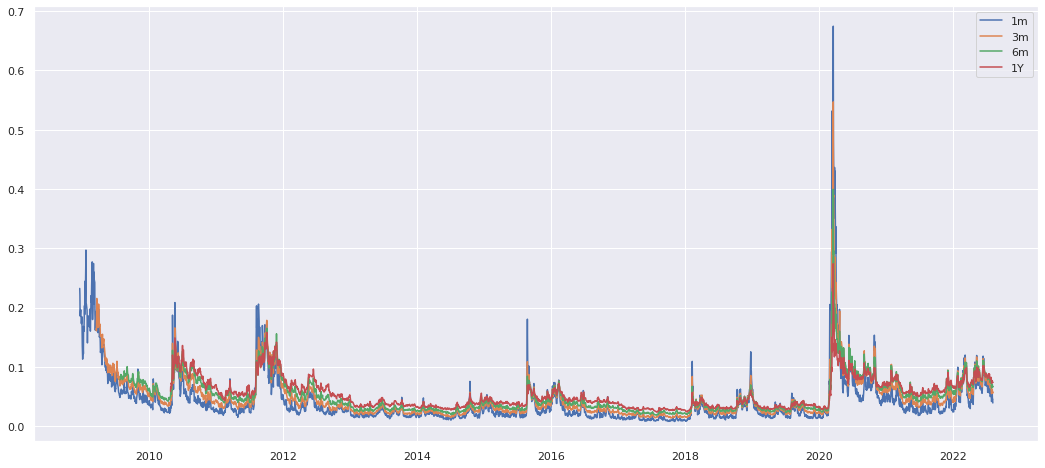

In [156]:
plt.figure(figsize=(18,8))
plt.plot(df_vsnm['Dates'],df_vsnm['1m'],label='1m')
plt.plot(df_vsnm['Dates'],df_vsnm['3m'],label='3m')
plt.plot(df_vsnm['Dates'],df_vsnm['6m'],label='6m')
plt.plot(df_vsnm['Dates'],df_vsnm['1Y'],label='1Y')
plt.legend()
plt.savefig("./aaaa.png")
plt.show()



In [107]:
# df_vsnm['1m'] = np.sqrt(df_vsnm['1m'])
# df_vsnm['3m'] = np.sqrt(df_vsnm['3m'])
# df_vsnm['6m'] = np.sqrt(df_vsnm['6m'])
# df_vsnm['1Y'] = np.sqrt(df_vsnm['1Y'])

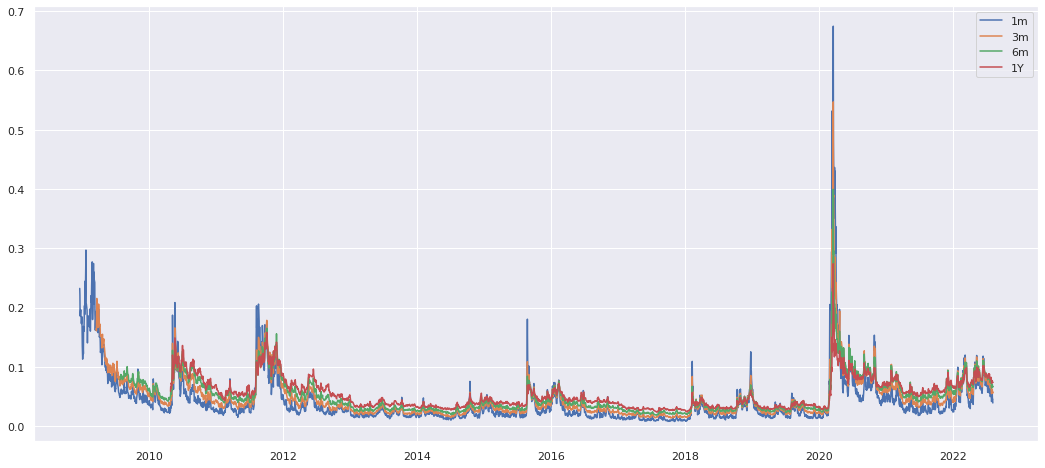

In [108]:
plt.figure(figsize=(18,8))
plt.plot(df_vsnm['Dates'],df_vsnm['1m'],label='1m')
plt.plot(df_vsnm['Dates'],df_vsnm['3m'],label='3m')
plt.plot(df_vsnm['Dates'],df_vsnm['6m'],label='6m')
plt.plot(df_vsnm['Dates'],df_vsnm['1Y'],label='1Y')
plt.legend()
plt.show()

In [109]:
def xi(date, tt, nu,h, tscale):  # dt=(u-t) is in units of years
    rvdata = pd.DataFrame(rv1['SPX.rsv'])
    return [ forecast_XTS(rvdata,h=h,date=date,nLags=500,delta=dt*tscale,nu=nu) for dt in tt]

nu = OxfordH[OxfordH['names']=='SPX.rsv']["nu_est"].values[0]
h = OxfordH[OxfordH['names']=='SPX.rsv']['h_est'].values[0]

def varSwapCurve(date, bigT, nSteps, nu, h, tscale, onFactor):
    # Make vector of fwd variances
    tt = [ float(i) * (bigT) / nSteps for i in range(nSteps+1)]
    delta_t = tt[1]
    xicurve = xi(date, tt, nu, h, tscale)
    xicurve_mid = (np.array(xicurve[0:nSteps]) + np.array(xicurve[1:nSteps+1])) / 2
    xicurve_int = np.cumsum(xicurve_mid) * delta_t
    varcurve1 = np.divide(xicurve_int, np.array(tt[1:]))
    varcurve = np.array([xicurve[0],]+list(varcurve1))
    varcurve = varcurve * onFactor * tscale #  onFactor is to compensate for overnight moves
    res = pd.DataFrame({"texp":np.array(tt), "vsQuote":np.sqrt(varcurve)})
    return(res)

In [110]:
def varSwapForecast(date,tau,nu,h,tscale,onFactor):
    vsc = varSwapCurve(date, bigT=2.5, nSteps=100, nu=nu, h=h,
                      tscale=tscale, onFactor=onFactor) # Creates the whole curve
    x = vsc['texp']
    y = vsc['vsQuote']
#     res = stineman_interp(tau,x,y,None)
    res = np.interp(tau,x,y,None)
  
    return(res)

# Test the function

tau = (.25,.5,1,2)
date = dt.datetime(2010,9,8)
varSwapForecast(date,tau,nu=nu,h=h,tscale=252,onFactor=1)

array([0.12309192, 0.13087859, 0.13961874, 0.14978644])

In [111]:
df_final = pd.merge(df_vsnm,df_rv_predict,how='left',on=['Dates'])
df_final

,Dates,1m,3m,6m,1Y,rv_predict
0,2008-12-17,0.232382,NaN,NaN,NaN,0.000377
1,2008-12-18,0.221041,NaN,NaN,NaN,0.000374
2,2008-12-19,0.185797,NaN,NaN,NaN,0.000293
3,2008-12-22,0.196609,NaN,NaN,NaN,0.000253
4,2008-12-23,0.195140,NaN,NaN,NaN,0.000232
...,...,...,...,...,...,...
3400,2022-08-01,0.048729,0.059911,0.067824,0.075345,NaN
3401,2022-08-02,0.053432,0.062657,0.070792,0.076985,NaN
3402,2022-08-03,0.045260,0.056390,0.065835,0.073273,NaN
3403,2022-08-04,0.045725,0.058155,0.067664,0.074432,NaN


In [112]:
df_final = df_final.dropna()
df_final

,Dates,1m,3m,6m,1Y,rv_predict
335,2010-04-26,0.025794,0.037691,0.049187,0.058872,0.000029
336,2010-04-27,0.049976,0.050865,0.058690,0.066728,0.000059
337,2010-04-28,0.043147,0.049853,0.059002,0.066526,0.000052
338,2010-04-29,0.030560,0.043785,0.053994,0.063820,0.000027
339,2010-04-30,0.046007,0.055025,0.064389,0.073040,0.000047
...,...,...,...,...,...,...
3372,2022-06-21,0.088131,0.090867,0.093808,0.090737,0.000118
3373,2022-06-22,0.083598,0.087692,0.091639,0.089044,0.000094
3374,2022-06-23,0.082771,0.086343,0.090704,0.088405,0.000088
3375,2022-06-24,0.068686,0.078945,0.084229,0.083684,0.000041


In [113]:
# print(np.sqrt(0.16))
# print(np.sqrt(0.000029*255))


In [114]:
df_final['rv_predict_30'] = df_final['rv_predict']*30

In [115]:
df_final

,Dates,1m,3m,6m,1Y,rv_predict,rv_predict_30
335,2010-04-26,0.025794,0.037691,0.049187,0.058872,0.000029,0.000871
336,2010-04-27,0.049976,0.050865,0.058690,0.066728,0.000059,0.001769
337,2010-04-28,0.043147,0.049853,0.059002,0.066526,0.000052,0.001550
338,2010-04-29,0.030560,0.043785,0.053994,0.063820,0.000027,0.000799
339,2010-04-30,0.046007,0.055025,0.064389,0.073040,0.000047,0.001408
...,...,...,...,...,...,...,...
3372,2022-06-21,0.088131,0.090867,0.093808,0.090737,0.000118,0.003548
3373,2022-06-22,0.083598,0.087692,0.091639,0.089044,0.000094,0.002834
3374,2022-06-23,0.082771,0.086343,0.090704,0.088405,0.000088,0.002646
3375,2022-06-24,0.068686,0.078945,0.084229,0.083684,0.000041,0.001217


In [116]:
df_final['log_1m_div_rv_predict'] = np.log(df_final['1m']/df_final['rv_predict_30'])
df_final

,Dates,1m,3m,6m,1Y,rv_predict,rv_predict_30,log_1m_div_rv_predict
335,2010-04-26,0.025794,0.037691,0.049187,0.058872,0.000029,0.000871,3.388619
336,2010-04-27,0.049976,0.050865,0.058690,0.066728,0.000059,0.001769,3.340874
337,2010-04-28,0.043147,0.049853,0.059002,0.066526,0.000052,0.001550,3.326327
338,2010-04-29,0.030560,0.043785,0.053994,0.063820,0.000027,0.000799,3.643904
339,2010-04-30,0.046007,0.055025,0.064389,0.073040,0.000047,0.001408,3.486729
...,...,...,...,...,...,...,...,...
3372,2022-06-21,0.088131,0.090867,0.093808,0.090737,0.000118,0.003548,3.212437
3373,2022-06-22,0.083598,0.087692,0.091639,0.089044,0.000094,0.002834,3.384441
3374,2022-06-23,0.082771,0.086343,0.090704,0.088405,0.000088,0.002646,3.443053
3375,2022-06-24,0.068686,0.078945,0.084229,0.083684,0.000041,0.001217,4.033303


In [117]:
# df_final['diff'] = df_final['log_1m_div_rv_predict'].diff()

In [118]:
# df_final['diff'] = df_final[['log_1m_div_rv_predict','diff']].apply(lambda x:x[0] if pd.isna(x[1]) else x[1],axis=1)

In [119]:
# df_final

In [120]:
# df_final['lambda'] = df_final['diff']/1.6556634023571712

In [121]:
# plt.figure(figsize=(24,8))
# plt.plot(df_final['Dates'],df_final['lambda'],label='lambda')

# plt.legend()
# plt.show()

In [122]:
import math
from scipy import integrate
h = OxfordH[OxfordH['names']=='SPX.rsv']['h_est'].values[0]
# h = -0.4
def obtain_integ(n,m):
    list_integ = []
    f = lambda x,a : (a-x)**(h-0.5)
    for i in range(n):
        y,err = integrate.quad(f, i, i+1, args=(n,))
        list_integ.append(y)
    list_integ = list_integ + [0 for _ in range(m-n)]
        
    return list_integ
def obtain_integ_2(n,m):
    list_integ = []
    f = lambda x,a : (a-x)**(2*h-1)
    for i in range(n):
        y,err = integrate.quad(f, i, i+1, args=(n,))
        list_integ.append(y)
    list_integ = list_integ + [0 for _ in range(m-n)]
        
    return list_integ

In [123]:
# list_integ = obtain_integ(10,df_final.shape[0])
# df_final['integ'] = list_integ
# df_final['lambda_integ'] = df_final['lambda']*df_final['integ']
# df_final['lambda_integ'] = df_final['lambda']*df_final['integ']
# df_final['sum_lambda_integ'] = sum(df_final['lambda_integ'])
# df_final['lambda'] = df_final[['log_1m_div_rv_predict','integ','lambda','sum_lambda_integ']].apply(lambda x: (x[0]-x[3])/x[1] if x[1]>0 and x[2]==0 else x[2],axis=1)
# df_final



In [143]:
# for i in range(1,df_final.shape[0]):
#     if i==1:
#         list_integ = obtain_integ(i,df_final.shape[0])
#         df_final['integ'] = list_integ
#         df_final['lambda'] = 0
#         df_final['lambda'] = df_final[['log_1m_div_rv_predict','integ','lambda']].apply(lambda x: x[0]/x[1] if x[1]>0 else x[2],axis=1)
#         df_final
#     else:
#         list_integ = obtain_integ(i,df_final.shape[0])
#         df_final['integ'] = list_integ
#         df_final['lambda_integ'] = df_final['lambda']*df_final['integ']
# #         df_final['lambda_integ'] = df_final['lambda']*df_final['integ']
#         df_final['sum_lambda_integ'] = sum(df_final['lambda_integ'])
#         df_final['lambda'] = df_final[['log_1m_div_rv_predict','integ','lambda','sum_lambda_integ']].apply(lambda x: (x[0]-x[3])/x[1] if x[1]>0 and x[2]==0 else x[2],axis=1)
#         df_final
i = 1
nu_hat = OxfordH[OxfordH['names']=='SPX.rsv']['nu_est'].values[0]
list_integ = obtain_integ(i,df_final.shape[0])
list_integ_2 = obtain_integ_2(i,df_final.shape[0])
df_final['integ'] = list_integ
df_final['integ'] = -2*df_final['integ']*rho_hat*nu_hat
df_final['integ_2'] = list_integ_2
df_final['integ_2'] = df_final['integ_2']*nu_hat**2
df_final['rho_hat_2'] = rho_hat**2
df_final['lambda'] = 0
df_final

,Dates,1m,3m,6m,1Y,rv_predict,rv_predict_30,log_1m_div_rv_predict,integ,integ_2,rho_hat_2,lambda,lambda_1,lambda_2,lambda_integ,sum_lambda_integ
335,2010-04-26,0.025794,0.037691,0.049187,0.058872,0.000029,0.000871,3.388619,-1.060381,1.054847,0.467432,0,0.000000+0.000000j,0.589716-2.077623j,4.350438,5.405285
336,2010-04-27,0.049976,0.050865,0.058690,0.066728,0.000059,0.001769,3.340874,-0.000000,0.000000,0.467432,0,1.134261+2.320911j,0.000000+0.000000j,1.054847,5.405285
337,2010-04-28,0.043147,0.049853,0.059002,0.066526,0.000052,0.001550,3.326327,-0.000000,0.000000,0.467432,0,0.000000+0.000000j,0.000000+0.000000j,0.000000,5.405285
338,2010-04-29,0.030560,0.043785,0.053994,0.063820,0.000027,0.000799,3.643904,-0.000000,0.000000,0.467432,0,0.000000+0.000000j,0.000000+0.000000j,0.000000,5.405285
339,2010-04-30,0.046007,0.055025,0.064389,0.073040,0.000047,0.001408,3.486729,-0.000000,0.000000,0.467432,0,0.000000+0.000000j,0.000000+0.000000j,0.000000,5.405285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3372,2022-06-21,0.088131,0.090867,0.093808,0.090737,0.000118,0.003548,3.212437,-0.000000,0.000000,0.467432,0,0.000000+0.000000j,0.000000+0.000000j,0.000000,5.405285
3373,2022-06-22,0.083598,0.087692,0.091639,0.089044,0.000094,0.002834,3.384441,-0.000000,0.000000,0.467432,0,0.000000+0.000000j,0.000000+0.000000j,0.000000,5.405285
3374,2022-06-23,0.082771,0.086343,0.090704,0.088405,0.000088,0.002646,3.443053,-0.000000,0.000000,0.467432,0,0.000000+0.000000j,0.000000+0.000000j,0.000000,5.405285
3375,2022-06-24,0.068686,0.078945,0.084229,0.083684,0.000041,0.001217,4.033303,-0.000000,0.000000,0.467432,0,0.000000+0.000000j,0.000000+0.000000j,0.000000,5.405285


In [144]:
df_final['lambda_1'] = df_final[['log_1m_div_rv_predict','integ','integ_2','rho_hat_2','lambda']].apply(lambda x: np.poly1d([x[3],x[1],-x[0]+x[2]]).r[0] if x[2]>0 else 0,axis=1)
df_final['lambda_2'] = df_final[['log_1m_div_rv_predict','integ','integ_2','rho_hat_2','lambda']].apply(lambda x: np.poly1d([x[3],x[1],-x[0]+x[2]]).r[1] if x[2]>0 else 0,axis=1)


In [154]:
for i in range(1,20):
    print(i)
    if i==1:
        list_integ = obtain_integ(i,df_final.shape[0])
        list_integ_2 = obtain_integ_2(i,df_final.shape[0])
        df_final['integ'] = list_integ
        df_final['integ'] = -2*df_final['integ']*rho_hat*nu_hat
        df_final['integ_2'] = list_integ_2
        df_final['integ_2'] = df_final['integ_2']*nu_hat**2
        df_final['rho_hat_2'] = rho_hat**2
        df_final['lambda_1'] = 0
        df_final['lambda_1'] = df_final[['log_1m_div_rv_predict','integ','integ_2','rho_hat_2','lambda_1']].apply(lambda x: np.poly1d([x[3],x[1],-x[0]+x[2]]).r[0] if x[2]>0 else 0,axis=1)
        df_final['lambda_2'] = df_final[['log_1m_div_rv_predict','integ','integ_2','rho_hat_2','lambda_1']].apply(lambda x: np.poly1d([x[3],x[1],-x[0]+x[2]]).r[1] if x[2]>0 else 0,axis=1)

    else:
        list_integ = obtain_integ(i,df_final.shape[0])
        list_integ_2 = obtain_integ_2(i,df_final.shape[0])
        df_final['integ'] = list_integ
        df_final['integ'] = -2*df_final['integ']*rho_hat*nu_hat
        df_final['integ_2'] = list_integ_2
        df_final['integ_2'] = df_final['integ_2']*nu_hat**2
        df_final['rho_hat_2'] = rho_hat**2
        
        
        df_final['lambda_integ'] = df_final[['lambda_2','integ','integ_2','rho_hat_2']].apply(lambda x:x[3]*x[0]**2+x[0]*x[1]+x[2],axis=1)
        df_final['sum_lambda_integ'] = sum(df_final['lambda_integ'])
        
        
        
        df_final['lambda_1'] = df_final[['log_1m_div_rv_predict','integ','integ_2','rho_hat_2','lambda_1','sum_lambda_integ']].apply(lambda x: np.poly1d([x[3],x[1],-x[0]+x[2]+x[5]]).r[0] if x[2]>0 and x[4]==0 else x[4],axis=1)
        df_final['lambda_2'] = df_final[['log_1m_div_rv_predict','integ','integ_2','rho_hat_2','lambda_2','sum_lambda_integ']].apply(lambda x: np.poly1d([x[3],x[1],-x[0]+x[2]+x[5]]).r[1] if x[2]>0 and x[4]==0 else x[4],axis=1)
print(df_final)
        
        
#         list_integ = obtain_integ(i,df_final.shape[0])
#         df_final['integ'] = list_integ
#         df_final['lambda_integ'] = df_final['lambda']*df_final['integ']
# #         df_final['lambda_integ'] = df_final['lambda']*df_final['integ']
# #         df_final['sum_lambda_integ'] = sum(df_final['lambda_integ'])
#         df_final['lambda'] = df_final[['log_1m_div_rv_predict','integ','lambda','sum_lambda_integ']].apply(lambda x: (x[0]-x[3])/x[1] if x[1]>0 and x[2]==0 else x[2],axis=1)
#         df_final

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
          Dates        1m        3m        6m        1Y  rv_predict  \
335  2010-04-26  0.025794  0.037691  0.049187  0.058872    0.000029   
336  2010-04-27  0.049976  0.050865  0.058690  0.066728    0.000059   
337  2010-04-28  0.043147  0.049853  0.059002  0.066526    0.000052   
338  2010-04-29  0.030560  0.043785  0.053994  0.063820    0.000027   
339  2010-04-30  0.046007  0.055025  0.064389  0.073040    0.000047   
...         ...       ...       ...       ...       ...         ...   
3372 2022-06-21  0.088131  0.090867  0.093808  0.090737    0.000118   
3373 2022-06-22  0.083598  0.087692  0.091639  0.089044    0.000094   
3374 2022-06-23  0.082771  0.086343  0.090704  0.088405    0.000088   
3375 2022-06-24  0.068686  0.078945  0.084229  0.083684    0.000041   
3376 2022-06-27  0.070359  0.076699  0.082780  0.083119    0.000067   

      rv_predict_30  log_1m_div_rv_predict     integ   integ_2  rho_hat_2  \
335        0.000871   

In [147]:
df_final

,Dates,1m,3m,6m,1Y,rv_predict,rv_predict_30,log_1m_div_rv_predict,integ,integ_2,rho_hat_2,lambda,lambda_1,lambda_2,lambda_integ,sum_lambda_integ
335,2010-04-26,0.025794,0.037691,0.049187,0.058872,0.000029,0.000871,3.388619,-0.551304,0.163571,0.467432,0,0.000000+0.000000j,0.000000+0.000000j,4.350438,5.405285
336,2010-04-27,0.049976,0.050865,0.058690,0.066728,0.000059,0.001769,3.340874,-1.060381,1.054847,0.467432,0,1.134261+2.320911j,1.134261-2.320911j,1.054847,5.405285
337,2010-04-28,0.043147,0.049853,0.059002,0.066526,0.000052,0.001550,3.326327,-0.000000,0.000000,0.467432,0,0.000000+0.000000j,0.000000+0.000000j,0.000000,5.405285
338,2010-04-29,0.030560,0.043785,0.053994,0.063820,0.000027,0.000799,3.643904,-0.000000,0.000000,0.467432,0,0.000000+0.000000j,0.000000+0.000000j,0.000000,5.405285
339,2010-04-30,0.046007,0.055025,0.064389,0.073040,0.000047,0.001408,3.486729,-0.000000,0.000000,0.467432,0,0.000000+0.000000j,0.000000+0.000000j,0.000000,5.405285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3372,2022-06-21,0.088131,0.090867,0.093808,0.090737,0.000118,0.003548,3.212437,-0.000000,0.000000,0.467432,0,0.000000+0.000000j,0.000000+0.000000j,0.000000,5.405285
3373,2022-06-22,0.083598,0.087692,0.091639,0.089044,0.000094,0.002834,3.384441,-0.000000,0.000000,0.467432,0,0.000000+0.000000j,0.000000+0.000000j,0.000000,5.405285
3374,2022-06-23,0.082771,0.086343,0.090704,0.088405,0.000088,0.002646,3.443053,-0.000000,0.000000,0.467432,0,0.000000+0.000000j,0.000000+0.000000j,0.000000,5.405285
3375,2022-06-24,0.068686,0.078945,0.084229,0.083684,0.000041,0.001217,4.033303,-0.000000,0.000000,0.467432,0,0.000000+0.000000j,0.000000+0.000000j,0.000000,5.405285


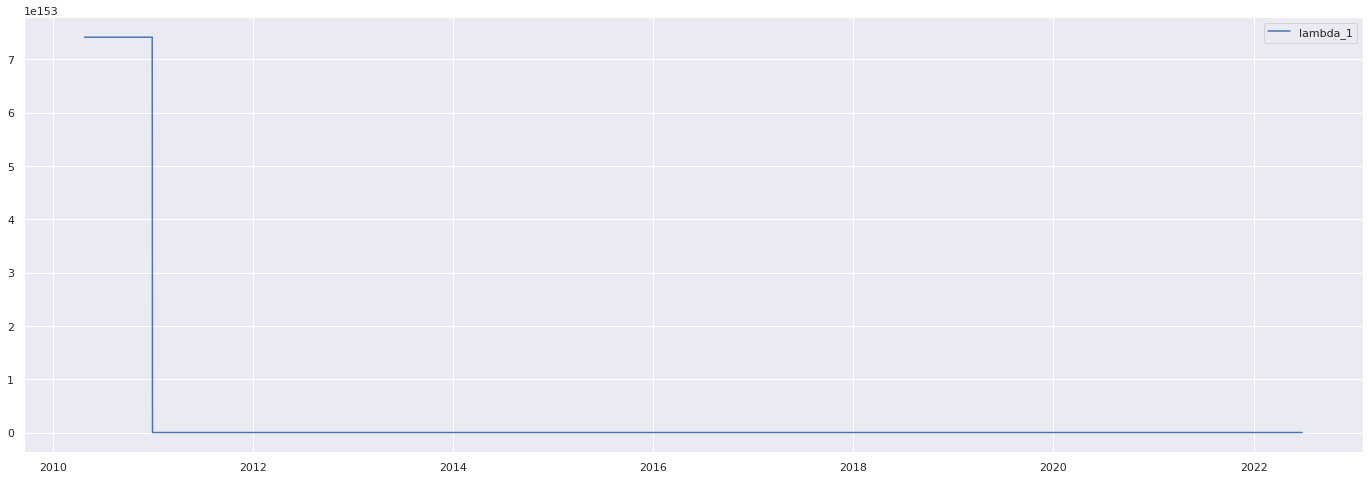

In [133]:
plt.figure(figsize=(24,8))
plt.plot(df_final['Dates'],df_final['lambda_1'],label='lambda_1')

plt.legend()
plt.show()

In [123]:
df_final['lambda'].mean()

0.00973430136423785

In [124]:
df_final[df_final['lambda']>0]

,Dates,1m,3m,6m,1Y,rv_predict,rv_predict_30,log_1m_div_rv_predict,integ,lambda,lambda_integ,sum_lambda_integ
335,2010-04-26,0.025794,0.037691,0.049187,0.058872,0.000029,0.007401,1.248553,0.041755,0.754110,0.031488,1.23311
336,2010-04-27,0.049976,0.050865,0.058690,0.066728,0.000059,0.015040,1.200808,0.041761,0.333202,0.013915,1.23311
337,2010-04-28,0.043147,0.049853,0.059002,0.066526,0.000052,0.013175,1.186261,0.041766,0.225199,0.009406,1.23311
338,2010-04-29,0.030560,0.043785,0.053994,0.063820,0.000027,0.006793,1.503838,0.041771,0.372824,0.015573,1.23311
339,2010-04-30,0.046007,0.055025,0.064389,0.073040,0.000047,0.011967,1.346663,0.041777,0.150430,0.006285,1.23311
...,...,...,...,...,...,...,...,...,...,...,...,...
3370,2022-06-16,0.114500,0.109638,0.109397,0.102229,0.000172,0.043949,0.957543,0.509494,0.004277,0.002179,1.23311
3372,2022-06-21,0.088131,0.090867,0.093808,0.090737,0.000118,0.030158,1.072371,0.610049,0.046691,0.028484,1.23311
3373,2022-06-22,0.083598,0.087692,0.091639,0.089044,0.000094,0.024086,1.244375,0.698289,0.109372,0.076373,1.23311
3374,2022-06-23,0.082771,0.086343,0.090704,0.088405,0.000088,0.022490,1.302987,0.860799,0.080333,0.069151,1.23311


In [125]:
# import numpy as np
# import matplotlib.pyplot as plt
# from hurst import compute_Hc, random_walk

# # Use random_walk() function or generate a random walk series manually:
# # series = random_walk(99999, cumprod=True)
# np.random.seed(42)
# random_changes = 1. + np.random.randn(99999) / 1000.
# series = np.cumprod(random_changes)  # create a random walk from random changes

# # Evaluate Hurst equation
# H, c, data = compute_Hc(series, kind='price', simplified=True)

# # Plot
# f, ax = plt.subplots()
# ax.plot(data[0], c*data[0]**H, color="deepskyblue")
# ax.scatter(data[0], data[1], color="purple")
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlabel('Time interval')
# ax.set_ylabel('R/S ratio')
# ax.grid(True)
# plt.show()

# print("H={:.4f}, c={:.4f}".format(H,c))

In [128]:
import numpy

numpy.poly1d([0.46,-1.06,-2.33]).r


array([ 3.68055721, -1.37620939])

In [160]:
from scipy.special import gamma
H = 0.103988
C_H = np.sqrt(2*H*gamma(3/2-H)/(gamma(H+1/2)*gamma(2-2*H)))
C_H

0.36632334842551434

In [161]:
eta = 2*nu_hat*C_H/np.sqrt(2*H)
eta

0.7524684808465273

In [159]:
nu_hat

0.46838214129329414